Lecture: AI I - Advanced 

Previous:
[**Chapter 3.1: PyTorch Lightning**](../../03_advanced/01_lightning.ipynb)

---

# Chapter 4.1.1: Computer Vision with Convolutional Neural Networks

In Chapter 2, PyTorch Lightning showed you how to organise and automate the training loop — separating data, model, and optimisation logic into clean, reusable blocks. You've been working with tabular data ever since the beginning: the Iris dataset, with its four numerical features per sample, fed directly into fully-connected layers.

Now we step into a completely different world: images. Images aren't rows of numbers in a table — they are grids of pixels, and the spatial arrangement of those pixels carries meaning. A stroke in the top-left corner of a digit and a stroke in the bottom-right corner together form a specific shape, but only because of where they are relative to each other. A fully-connected network has no way to exploit this structure. It sees a flat list of numbers and has to learn spatial relationships from scratch, which is expensive and wasteful.

This excursion introduces **Convolutional Neural Networks (CNNs)** — architectures specifically designed for grid-structured data like images. We start with the simplest possible image dataset, solve it first with a plain feedforward network to establish a baseline, and then build up to a CNN that is architecturally inspired by AlexNet, one of the models that kicked off the modern deep learning era.

## The MNIST Dataset

MNIST (Modified National Institute of Standards and Technology) is the "Hello World" of machine learning. It contains 70,000 handwritten digit images, each one a 28×28 pixel grayscale image of a single digit from 0 to 9.

| Property | Value |
|----------|-------|
| Training images | 60,000 |
| Test images | 10,000 |
| Image size | 28×28 pixels |
| Color channels | 1 (grayscale) |
| Classes | 10 (digits 0–9) |
| Pixel value range | 0 (Black) – 255 (White) |

Each image is stored as a 2D grid of pixel intensities. The digit "3", for example, is not defined by a single pixel value — it's defined by the pattern of bright pixels against a dark background. That pattern has structure: curves, lines, and their spatial relationships. This is exactly the kind of information that CNNs are built to capture.

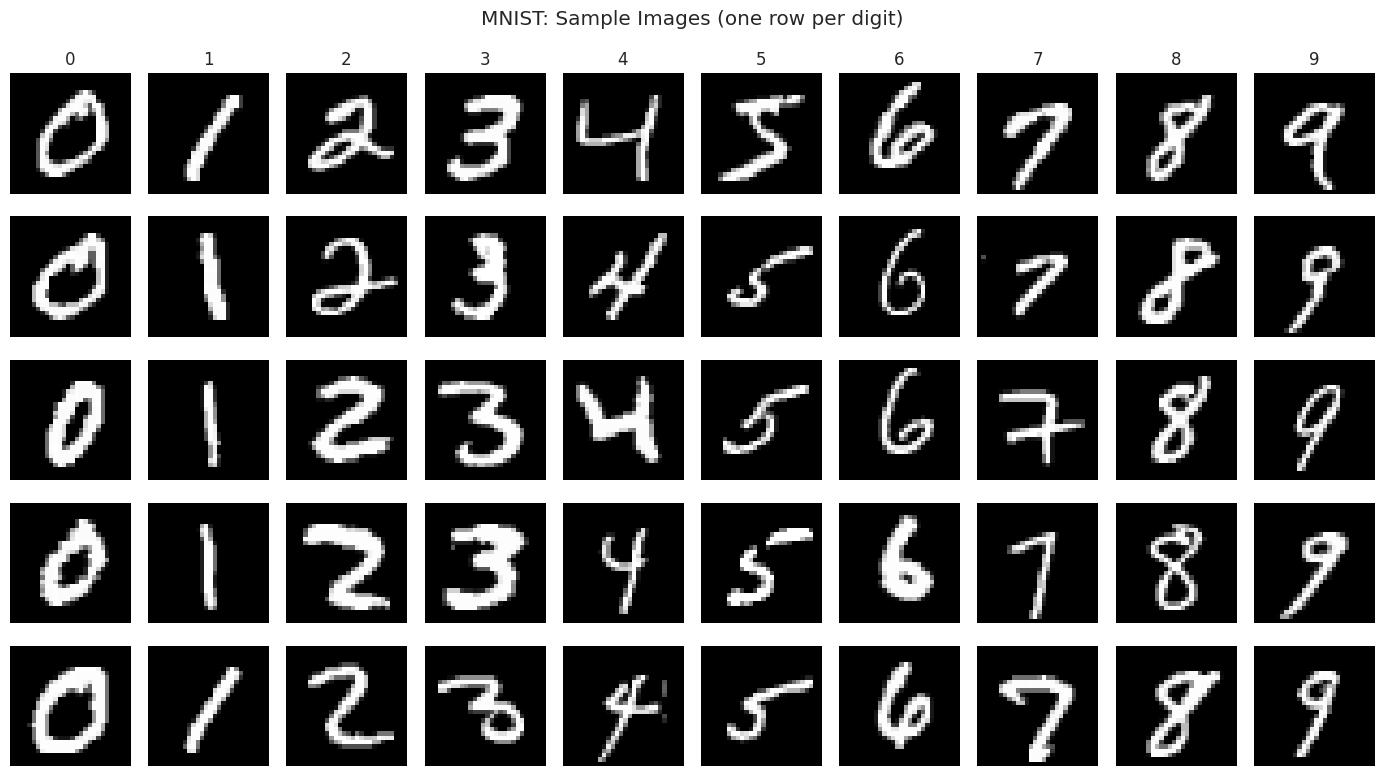

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),   # PIL Image (H, W) → Tensor (1, H, W), scales to [0, 1]
])

train_dataset = datasets.MNIST(root="./data/01_cnn", train=True,  download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data/01_cnn", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(5, 10, figsize=(14, 8))

samples_per_digit = {d: [] for d in range(10)}
for img, label in train_dataset:
    if len(samples_per_digit[label]) < 5:
        samples_per_digit[label].append(img)
    if all(len(v) == 5 for v in samples_per_digit.values()):
        break

for row in range(5):
    for col in range(10):
        axes[row, col].imshow(samples_per_digit[col][row].squeeze(), cmap="gray")
        axes[row, col].axis("off")
        if row == 0:
            axes[row, col].set_title(str(col))

fig.suptitle("MNIST: Sample Images (one row per digit)")
fig.tight_layout()

## Solving MNIST with a Feedforward Network

Before we introduce CNNs, let's solve MNIST the "naive" way — with a plain feedforward network, the same architecture we've been using since Chapter 1. This gives us a baseline to compare against and makes the limitations of fully-connected layers on image data concrete.

### The Flatten Problem

A fully-connected (`nn.Linear`) layer expects a 1D vector as input. But our images are 2D grids (28×28). To feed an image into a Linear layer, we have to flatten it: reshape the 28×28 grid into a single vector of 784 numbers.

This works — the network can learn to classify digits from a flat vector — but it has to discover spatial patterns entirely from scratch, which requires more parameters and more data than necessary. CNNs solve this by operating directly on the 2D structure.

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class FeedforwardClassifier(nn.Module):

    def __init__(self, input_size=784, hidden_size=384, num_classes=10):
        super().__init__()
        self.flatten  = nn.Flatten()
        self.fc1      = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2      = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3      = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


# Instantiate and count parameters
model = FeedforwardClassifier()
total_params = sum(p.numel() for p in model.parameters())
print(f"Feedforward model parameters: {total_params:,}")

Feedforward model parameters: 453,130


### Training and Evaluation Helper

We'll reuse this helper for both the feedforward and CNN models so the comparison is fair.

In [24]:
import torch

def train_and_evaluate(model, train_loader, test_loader, epochs=10, lr=0.001):
    """Train a model and return history + final test accuracy."""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, train_accs = [], []
    test_losses,  test_accs  = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            logits = model(images)
            loss   = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * images.size(0)
            correct    += (logits.argmax(dim=1) == labels).sum().item()
            total      += images.size(0)

        train_losses.append(epoch_loss / total)
        train_accs.append(correct / total)

        model.eval()
        eval_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in test_loader:
                logits = model(images)
                loss   = criterion(logits, labels)

                eval_loss += loss.item() * images.size(0)
                correct   += (logits.argmax(dim=1) == labels).sum().item()
                total     += images.size(0)

        test_losses.append(eval_loss / total)
        test_accs.append(correct / total)

        print(f"Epoch {epoch+1:2d}/{epochs} | "
              f"Train Loss: {train_losses[-1]:.4f}  Acc: {train_accs[-1]:.4f} | "
              f"Test Loss:  {test_losses[-1]:.4f}  Acc: {test_accs[-1]:.4f}")

    return {
        "train_loss": train_losses, "train_acc": train_accs,
        "test_loss":  test_losses,  "test_acc":  test_accs,
    }


ff_history = train_and_evaluate(model, train_loader, test_loader, epochs=10)

Epoch  1/10 | Train Loss: 0.2913  Acc: 0.9123 | Test Loss:  0.1172  Acc: 0.9634
Epoch  2/10 | Train Loss: 0.1259  Acc: 0.9616 | Test Loss:  0.0941  Acc: 0.9698
Epoch  3/10 | Train Loss: 0.0953  Acc: 0.9710 | Test Loss:  0.0750  Acc: 0.9775
Epoch  4/10 | Train Loss: 0.0796  Acc: 0.9754 | Test Loss:  0.0721  Acc: 0.9781
Epoch  5/10 | Train Loss: 0.0702  Acc: 0.9773 | Test Loss:  0.0680  Acc: 0.9798
Epoch  6/10 | Train Loss: 0.0610  Acc: 0.9801 | Test Loss:  0.0675  Acc: 0.9789
Epoch  7/10 | Train Loss: 0.0547  Acc: 0.9819 | Test Loss:  0.0714  Acc: 0.9788
Epoch  8/10 | Train Loss: 0.0492  Acc: 0.9839 | Test Loss:  0.0652  Acc: 0.9826
Epoch  9/10 | Train Loss: 0.0450  Acc: 0.9854 | Test Loss:  0.0780  Acc: 0.9782
Epoch 10/10 | Train Loss: 0.0445  Acc: 0.9857 | Test Loss:  0.0738  Acc: 0.9796


## Why Feedforward Networks Are Wasteful on Images

Before we move to CNNs, let's make the problem concrete. Look at what happens when you flatten an image and feed it into a fully-connected layer:

**Parameter explosion**: The first Linear layer alone needs 784 × 384 = 301,056 weights. Every single input pixel is connected to every single neuron. Most of these connections are meaningless — pixel [0, 0] (top-left corner) has nothing to do with pixel [27, 27] (bottom-right corner), but the network dedicates a learnable weight to their connection anyway.

**No spatial awareness**: After flattening, the network treats the pixel sequence as arbitrary. If you permuted the pixels randomly (shuffled their positions), the network would need to relearn everything from scratch. A CNN, by contrast, would break immediately — because it relies on spatial structure.

**No weight sharing**: The same visual pattern (say, a curved stroke) can appear anywhere in the image. A fully-connected layer learns a separate set of weights for detecting that pattern at each position. A CNN uses the same weights everywhere — a huge efficiency gain.

This is the motivation for convolutions. They are not just "another layer type" — they are a fundamentally different way of processing grid-structured data.

## Convolutions: The Core Idea

A convolution slides a small kernel (also called a filter) across the image and computes a dot product at every position. The kernel is typically small — $3×3$ or $5×5$ — and it captures a local pattern.

Think of it as a magnifying glass with a fixed pattern printed on it. You slide it over every patch of the image. Where the image matches the pattern, the output is high. Where it doesn't match, the output is low. The result is a new 2D grid — called a feature map — that highlights where that particular pattern appeared in the original image.

```
Input image (5×5)        Kernel (3×3)         
                                              
┌───┬───┬───┬───┬───┐   ┌───┬───┬───┐        
│ 1 │ 2 │ 3 │ 0 │ 1 │   │-1 │ 0 │ 1 │        This 3×3 kernel slides
├───┼───┼───┼───┼───┤   ├───┼───┼───┤        across the input image.
│ 0 │ 1 │ 2 │ 1 │ 0 │   │-1 │ 0 │ 1 │        
├───┼───┼───┼───┼───┤   ├───┼───┼───┤        At each position, we compute
│ 2 │ 1 │ 0 │ 1 │ 2 │   │-1 │ 0 │ 1 │        the dot product between the
├───┼───┼───┼───┼───┤   └───┴───┴───┘        kernel and the 3×3 patch of
│ 1 │ 0 │ 1 │ 2 │ 1 │                        the image under it.
├───┼───┼───┼───┼───┤   
│ 0 │ 1 │ 2 │ 0 │ 1 │   This particular kernel
└───┴───┴───┴───┴───┘   detects vertical edges.


Example: sliding the kernel over position (0,0) of the input
┌───┬───┬───┐
│ 1 │ 2 │ 3 │  ×  kernel  =  (1×-1) + (2×0) + (3×1)
├───┼───┼───┤             +  (0×-1) + (1×0) + (2×1)
│ 0 │ 1 │ 2 │             +  (2×-1) + (1×0) + (0×1)  =  2
├───┼───┼───┤
│ 2 │ 1 │ 0 │
└───┴───┴───┘

After sliding across all valid positions → 3×3 output feature map
```

The kernel above (−1, 0, +1 repeated vertically) is a classic edge detector: it computes the difference between the left and right sides of each 3×3 patch. Where there's a sharp transition from dark to bright (a vertical edge), the output is large. Where the image is uniform, the output is near zero.

### Key Properties

**Weight sharing**: The same kernel is applied at every position in the image. A 3×3 kernel has only 9 learnable weights, regardless of image size. Compare this to a fully-connected layer, which needs a separate weight for every input-output pair.

**Local connectivity**: Each output value depends on only a small neighbourhood (3×3 or 5×5 pixels), not the entire image. This is a strong inductive bias: nearby pixels are more likely to be related than distant pixels.

**Learned kernels**: In a trained CNN, the kernels are not hand-designed — they are learned during backpropagation, just like any other weights. Early layers typically learn simple patterns (edges, corners), and deeper layers combine these into increasingly complex features (curves, textures, object parts).

### Visualising Learned Kernels

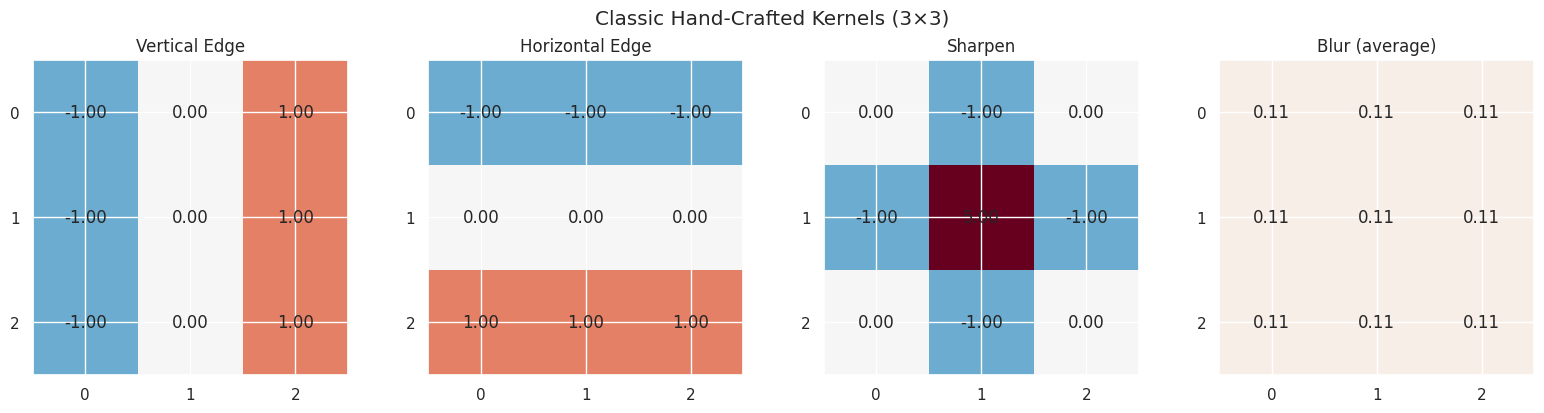

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Classic Hand-Crafted Kernels (3×3)")

kernels = {
    "Vertical Edge":   [[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]],
    "Horizontal Edge": [[-1,-1,-1], [ 0, 0, 0], [ 1, 1, 1]],
    "Sharpen":         [[ 0,-1, 0], [-1, 5,-1], [ 0,-1, 0]],
    "Blur (average)":  [[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]],
}

for ax, (name, kernel) in zip(axes, kernels.items()):
    ax.imshow(kernel, cmap="RdBu_r", vmin=-2, vmax=2, aspect="equal")
    ax.set_title(name)
    ax.set_xticks(range(3))
    ax.set_yticks(range(3))

    for i in range(3):
        for j in range(3):
            ax.text(j, i, f"{kernel[i][j]:.2f}", ha="center", va="center",)

fig.tight_layout()

## Pooling: Shrinking Feature Maps

Convolutions preserve (or nearly preserve) the spatial size of the input. After several conv layers, the feature maps are still large — and stacking more layers on top gets expensive fast. Pooling solves this by downsampling the feature map while retaining the most important information.

### Max Pooling

The most common type. The feature map is divided into non-overlapping patches (typically 2×2), and the maximum value in each patch is kept. This halves both dimensions: a 28×28 feature map becomes 14×14.

```
Feature map (4×4)          Split into 2×2 patches         Take max of each

┌───┬───┬───┬───┐         ┌───────┬───────┐             ┌───┬───┐
│ 1 │ 3 │ 2 │ 4 │         │ 1   3 │ 2   4 │             │ 5 │ 4 │
├───┼───┼───┼───┤    →    │ 2   5 │ 1   3 │      →      ├───┼───┤
│ 2 │ 5 │ 1 │ 3 │         ├───────┼───────┤             │ 6 │ 5 │
├───┼───┼───┼───┤         │ 4   1 │ 3   2 │             └───┴───┘
│ 4 │ 1 │ 3 │ 2 │         │ 6   2 │ 5   1 │
├───┼───┼───┼───┤         └───────┴───────┘             Output: 2×2
│ 6 │ 2 │ 5 │ 1 │         
└───┴───┴───┴───┘         max(1,3,2,5)=5  max(2,4,1,3)=4    
                          max(4,1,6,2)=6  max(3,2,5,1)=5
```

Why max pooling works: If a feature detector fired strongly somewhere in a 2×2 region, it doesn't matter exactly where — the feature is present. Max pooling preserves that signal while discarding the precise location. This makes the representation slightly translation-invariant: a feature detected one pixel to the left still produces the same output after pooling.

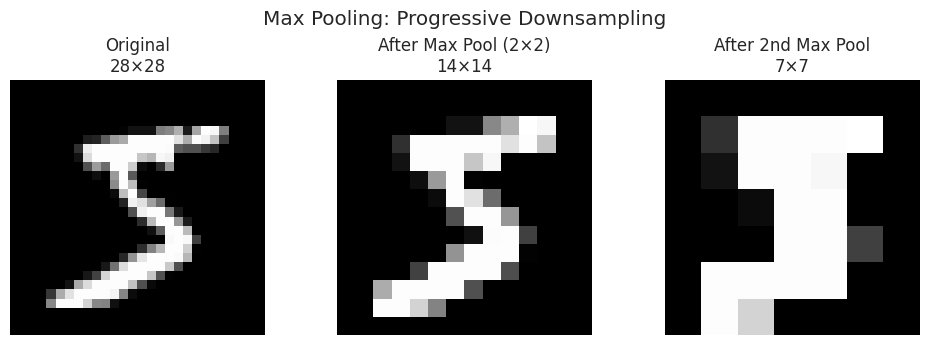

In [ ]:
sample_image = train_dataset[0][0]  # shape: (1, 28, 28)

fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))

axes[0].imshow(sample_image.squeeze(), cmap="gray")
axes[0].set_title(f"Original\n{sample_image.shape[1]}×{sample_image.shape[2]}")
axes[0].axis("off")

pooled = F.max_pool2d(sample_image.unsqueeze(0), kernel_size=2, stride=2)
axes[1].imshow(pooled.squeeze(), cmap="gray")
axes[1].set_title(f"After Max Pool (2×2)\n{pooled.shape[2]}×{pooled.shape[3]}")
axes[1].axis("off")

pooled2 = F.max_pool2d(pooled, kernel_size=2, stride=2)
axes[2].imshow(pooled2.squeeze(), cmap="gray")
axes[2].set_title(f"After 2nd Max Pool\n{pooled2.shape[2]}×{pooled2.shape[3]}")
axes[2].axis("off")

fig.suptitle("Max Pooling: Progressive Downsampling")
fig.tight_layout()

## CNN Architecture: AlexNet-Inspired Model

AlexNet (Krizhevsky et al., 2012) was the model that showed the world what deep CNNs could do. It won the ImageNet competition by a massive margin, sparking the modern deep learning era. Its structure is simple and influential:
1. A stack of conv layers to extract increasingly abstract features
1. Max pooling after some conv layers to shrink spatial dimensions
1. A flatten step
1. Fully-connected layers for the final classification

AlexNet itself was designed for 224×224 colour images with 1000 classes. Our MNIST images are 28×28 grayscale with 10 classes, so we build a smaller version that follows the same architectural philosophy but is appropriately sized for our task.

```
Input: 1 × 28 × 28  (1 channel, 28×28 pixels)
         │
         ▼
    Conv2d(1→32, 3×3)  →  ReLU                   32 × 28 × 28
         │
         ▼
    Conv2d(32→32, 3×3) →  ReLU  →  MaxPool(2×2)  32 × 13 × 13
         │
         ▼
    Conv2d(32→64, 3×3) →  ReLU                   64 × 11 × 11
         │
         ▼
    Conv2d(64→64, 3×3) →  ReLU  →  MaxPool(2×2)  64 ×  5 ×  5
         │
         ▼
    Flatten                                      1600
         │
         ▼
    Linear(1600→128)   →  ReLU  →  Dropout(0.5)  128
         │
         ▼
    Linear(128→10)                               10 (logits)
```

The pattern is clear: conv layers come in pairs, the second one is followed by pooling. Each pooling step halves the spatial size and the next pair of convolutions doubles the number of feature maps. This is the classic "narrow and deep" progression that AlexNet popularised.

### Implementation

In [16]:
class CNNModel(nn.Module):
    """
    A smaller AlexNet-inspired CNN for MNIST.

    AlexNet's key ideas applied here:
    - Pairs of conv layers before each pooling step
    - Increasing number of feature maps as spatial size shrinks
    - Dropout in the fully-connected layers to prevent overfitting
    - ReLU activations throughout
    """
    def __init__(self, num_classes=10):
        super().__init__()

        # Feature extraction (convolutional backbone)
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),   # 1×28×28  -> 32×28×28
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # 32×28×28 -> 32×28×28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # 32×28×28 -> 32×14×14
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 32×14×14 -> 64×14×14
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # 64×14×14 -> 64×14×14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # 64×14×14 -> 64×7×7
        )

        # Classification head (fully connected)
        self.classifier = nn.Sequential(
            nn.Flatten(),                                  # 64×7×7 -> 3136
            nn.Linear(64 * 7 * 7, 128),                    # 3136 -> 128
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),                   # 128 -> 10
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Instantiate and count parameters
cnn_model = CNNModel()
cnn_params = sum(p.numel() for p in cnn_model.parameters())
print(f"CNN Model parameters: {cnn_params:,}")

CNN Model parameters: 467,818


## Training the CNN

In [17]:
cnn_history = train_and_evaluate(cnn_model, train_loader, test_loader, epochs=10)

Epoch  1/10 | Train Loss: 0.2245  Acc: 0.9309 | Test Loss:  0.0399  Acc: 0.9863
Epoch  2/10 | Train Loss: 0.0787  Acc: 0.9771 | Test Loss:  0.0296  Acc: 0.9898
Epoch  3/10 | Train Loss: 0.0553  Acc: 0.9829 | Test Loss:  0.0258  Acc: 0.9906
Epoch  4/10 | Train Loss: 0.0463  Acc: 0.9862 | Test Loss:  0.0224  Acc: 0.9934
Epoch  5/10 | Train Loss: 0.0392  Acc: 0.9886 | Test Loss:  0.0208  Acc: 0.9930
Epoch  6/10 | Train Loss: 0.0322  Acc: 0.9900 | Test Loss:  0.0235  Acc: 0.9923
Epoch  7/10 | Train Loss: 0.0289  Acc: 0.9912 | Test Loss:  0.0215  Acc: 0.9933
Epoch  8/10 | Train Loss: 0.0253  Acc: 0.9921 | Test Loss:  0.0218  Acc: 0.9937
Epoch  9/10 | Train Loss: 0.0231  Acc: 0.9927 | Test Loss:  0.0211  Acc: 0.9936
Epoch 10/10 | Train Loss: 0.0202  Acc: 0.9935 | Test Loss:  0.0233  Acc: 0.9924


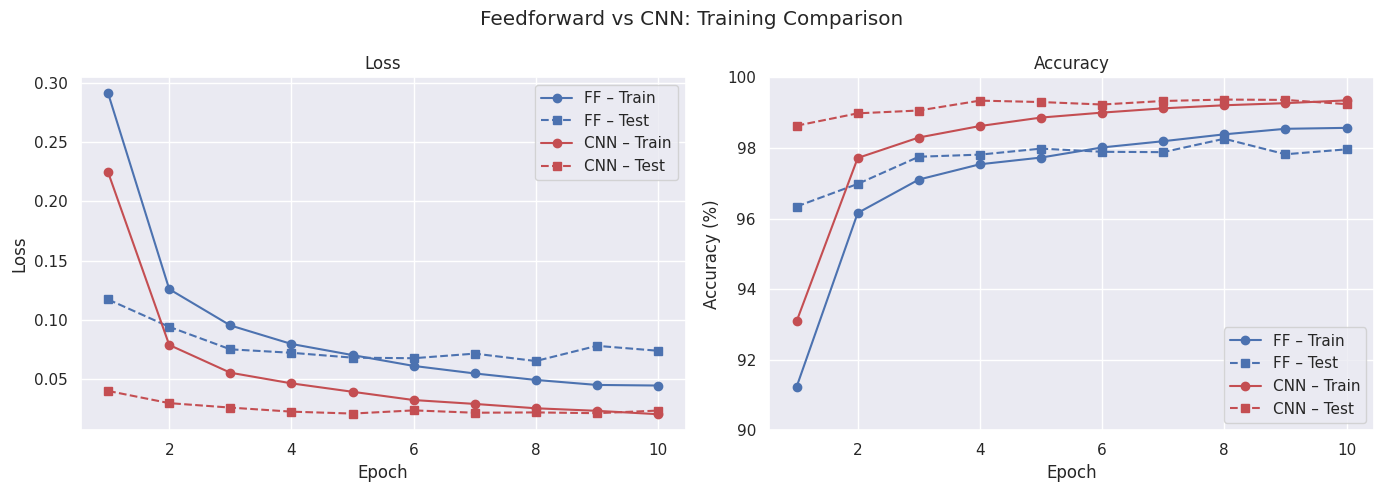

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Feedforward vs CNN: Training Comparison")

epochs = range(1, len(ff_history["train_acc"]) + 1)

axes[0].plot(epochs, ff_history["train_loss"], "o-", color="C0", label="FF – Train")
axes[0].plot(epochs, ff_history["test_loss"],  "s--", color="C0", label="FF – Test")
axes[0].plot(epochs, cnn_history["train_loss"], "o-", color="C3", label="CNN – Train")
axes[0].plot(epochs, cnn_history["test_loss"],  "s--", color="C3", label="CNN – Test")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss")
axes[0].legend()

axes[1].plot(epochs, [a * 100 for a in ff_history["train_acc"]], "o-", color="C0", label="FF – Train")
axes[1].plot(epochs, [a * 100 for a in ff_history["test_acc"]],  "s--", color="C0", label="FF – Test")
axes[1].plot(epochs, [a * 100 for a in cnn_history["train_acc"]], "o-", color="C3", label="CNN – Train")
axes[1].plot(epochs, [a * 100 for a in cnn_history["test_acc"]],  "s--", color="C3", label="CNN – Test")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Accuracy")
axes[1].legend()
axes[1].set_ylim([90, 100])

fig.tight_layout()

In [26]:
print("\n" + "=" * 50)
print(f"  {'Model':<20} {'Params':>10} {'Test Acc':>10}")
print("=" * 50)
print(f"  {'Feedforward':<20} {total_params:>10,} {ff_history['test_acc'][-1]*100:>9.2f}%")
print(f"  {'CNN Model':<20} {cnn_params:>10,} {cnn_history['test_acc'][-1]*100:>9.2f}%")
print("=" * 50)


  Model                    Params   Test Acc
  Feedforward             453,130     97.96%
  CNN Model               467,818     99.24%


## Beyond AlexNet: A Glimpse at Modern Architectures

AlexNet (2012) established the template that CNNs still follow today: stacked conv layers, pooling for downsampling, fully-connected layers at the end. But the field didn't stop there. Modern architectures have pushed accuracy far beyond AlexNet's original results through clever innovations that address specific problems.

### ResNet (2015): Going Deeper with Skip Connections

The problem AlexNet couldn't solve: Stacking more layers should make networks more powerful, but in practice, very deep networks (50+ layers) suffered from vanishing gradients. The gradient signal became weaker and weaker as it propagated backward through dozens of layers, and early layers stopped learning entirely.

ResNet's solution: Skip connections (also called residual connections). Instead of forcing each layer to learn a transformation from scratch, ResNet lets layers learn the residual (the difference between input and desired output). Mathematically:

```
Traditional:  output = F(x)          (layer learns the full transformation)
ResNet:       output = F(x) + x      (layer learns only the difference)
                       └─────┘
                    skip connection
```

The `+ x` is a direct path from input to output that bypasses the layer. If a layer isn't helpful, gradients can flow through the skip connection unchanged. This simple idea allowed networks to scale from 8 layers (AlexNet) to 152 layers (ResNet-152) — and even deeper.

Impact: ResNet won ImageNet 2015 and remains the backbone architecture for countless computer vision applications. Variants like ResNeXt and EfficientNet build on the same residual principle.

### YOLO (2015): Real-Time Object Detection

The problem AlexNet couldn't solve: AlexNet classifies entire images — it tells you "this image contains a dog." But what if you need to find where the dog is, and if there are multiple objects? Traditional approaches ran a classifier on thousands of sliding windows across the image, which was painfully slow.

YOLO's solution: You Only Look Once. YOLO divides the image into a grid (e.g., 7×7) and predicts bounding boxes and class probabilities for each grid cell in a single forward pass. No sliding windows. No region proposals. Just one CNN evaluation.

### Other Key Innovations

**VGG (2014)**: Showed that very small (3×3) filters stacked deeply work better than large (11×11) filters. Simpler architecture, easier to understand.

**Inception / GoogLeNet (2014)**: Introduced "inception modules" that apply multiple filter sizes (1×1, 3×3, 5×5) in parallel and concatenate results. Lets the network choose which scale of feature is most useful at each layer.

**MobileNet (2017)**: Designed for mobile devices. Uses depthwise separable convolutions to drastically reduce computation while maintaining decent accuracy.

**EfficientNet (2019)**: Systematically optimized depth, width, and resolution together using a compound scaling method. Achieved state-of-the-art accuracy with fewer parameters than older models.

**Vision Transformers (2020)**: Abandoned convolutions entirely. Applied the Transformer architecture (the same one powering GPT and BERT) directly to image patches. Competitive with CNNs on large datasets but requires massive amounts of training data.

### What They All Share

Despite their differences, every modern architecture builds on the same core ideas you've learned in this chapter:

- Convolutions to extract local features with weight sharing
- Pooling or stride-based downsampling to reduce spatial dimensions
- Learned hierarchies: early layers detect edges, middle layers detect textures/parts, deep layers detect objects
- End-to-end learning: gradients flow through the entire network, optimizing all layers jointly

AlexNet proved that deep CNNs work. ResNet proved they can go much deeper. YOLO proved they can go much faster. The next generation is still being invented.

---

Lecture: AI I - Advanced 

Exercise: [**Exercise 2.1: Python Basics**](../02_python/exercises/01_basics.ipynb)

Next: [**Chapter 4.2.1: Transformers**](../02_nlp/01_gpt2.ipynb)